# **V6**: simplify...

In [21]:
#@title Import toolkits
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats  
from scipy.stats import zscore
import scipy.stats as st
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [22]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [6, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [23]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [24]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

In [25]:
# @title Dict building
# extract usful data from each session:
# name, stimulus_right, stimulus_left, response

name = []
temp_stim_r = []
temp_stim_l = []
temp_resp = []
temp_rw = []
newDict = {'name':name,'stim_r':temp_stim_r,'stim_l':temp_stim_l,'resp':temp_resp,'reward':temp_rw}
for ses in range(len(alldat)): # per session
  name.append(alldat[ses]['mouse_name'])
  if ses==0:
    temp_stim_r = [alldat[ses]['contrast_right']]
    newDict['stim_r'] = [temp_stim_r[0]] 
    # with [0] so that the type of the 1st element in newDict['stim_r'] 
    # wont be list, but ndarray, which is same as the following ones
    temp_stim_l = [alldat[ses]['contrast_left']]
    newDict['stim_l'] = [temp_stim_l[0]]
    temp_resp = [alldat[ses]['response']]
    newDict['resp'] = [temp_resp[0]]
    
    temp_rw = [alldat[ses]['feedback_type']]
    newDict['reward'] = [temp_rw[0]] 
  else:
    temp_stim_r = newDict['stim_r']
    temp_stim_r.append(alldat[ses]['contrast_right'])
    newDict['stim_r'] = temp_stim_r
    temp_stim_l = newDict['stim_l']
    temp_stim_l.append(alldat[ses]['contrast_left'])
    newDict['stim_l'] = temp_stim_l
    temp_resp = newDict['resp']
    temp_resp.append(alldat[ses]['response'])
    newDict['resp'] = temp_resp

    temp_rw = newDict['reward']
    temp_rw.append(alldat[ses]['feedback_type'])
    newDict['reward'] = temp_rw

# unique names
unique_name = []
for ses in range(len(name)):
  if ses==0:
    unique_name.append(name[ses])
  else:
    same = []
    for i in range(len(unique_name)):
      same.append(name[ses]==unique_name[i]) # this name has been met
    if sum(same)==0: # this name has NOT been met yet
      unique_name.append(name[ses])

In [26]:
# @title Trials counting
# per stimComb per session

ses_total_count = []
temp_comb_index = []
newDict.update({'comb_index':temp_comb_index})
for ses in range(len(newDict['name'])): # per session
  unique_stim_r = []
  unique_stim_r = np.unique(newDict['stim_r'][ses])
  unique_stim_l = []
  unique_stim_l = np.unique(newDict['stim_l'][ses])
  index_comb_lR = []
  index_comb_Lr = []
  index_comb_00 = []
  comb_index = list()
  comb_map = np.zeros((len(unique_stim_r),len(unique_stim_l)))
  total_count = np.zeros((len(unique_stim_r),len(unique_stim_l)))

  counter = 0
  for stim_r in range(len(unique_stim_r)):
    a_r = []
    a_r = np.where(newDict['stim_r'][ses]==unique_stim_r[stim_r])[0] + 1
    #index - +1 so that the 1st (0,0) conditioned trial (if any) wont be missed
    for stim_l in range(len(unique_stim_l)):
      a_l = []
      a_l = np.where(newDict['stim_l'][ses]==unique_stim_l[stim_l])[0] + 1
      #index - +1 so that the 1st (0,0) conditioned trial (if any) wont be missed
      
      #highlight the identical indexes, but pale the others
      a = []
      for i in range(len(a_r)): # check if there is identical index
        if sum(a_l==a_r[i]):
          a += [1]
        else:
          a += [0]
      temp_a = a_r * a 
      temp_a_list = temp_a[temp_a>0] - 1 # -1 so that it can be used as index!
      total_count[abs(stim_l-3),stim_r] = len(temp_a_list)
      comb_index.append(temp_a_list) #trials belonging to specific stimComb

      #results below are same in each session:
      if unique_stim_l[stim_l] > unique_stim_r[stim_r]:
        index_comb_Lr += [len(comb_index)-1]
      if unique_stim_l[stim_l] < unique_stim_r[stim_r]:
        index_comb_lR += [len(comb_index)-1]
      if (stim_l==0 and stim_r==0):
        index_comb_00 = [len(comb_index)-1, [abs(stim_l-3),stim_r]]
      # ↑ index_comb_00[0] is the index of stimComb (0,0) in 1-d comb_index, = 0
      # ↑ index_comb_00[1] is that in total_count, = [3,0]
      counter += 1
      comb_map[abs(stim_l-3),stim_r] = counter
      # ↑ because the variable 'comb_index' is 1-d,
      # this matrix can help match each row of data with the 2-d stimComb matrix
  
  temp_comb_index = newDict['comb_index']
  temp_comb_index.append(comb_index)
  newDict['comb_index'] = temp_comb_index # key-value: session-#trial_per_stimComb
  ses_total_count.append(total_count)


Text(16.94444444444445, 0.5, 'contrast$_{left}$  (%)')

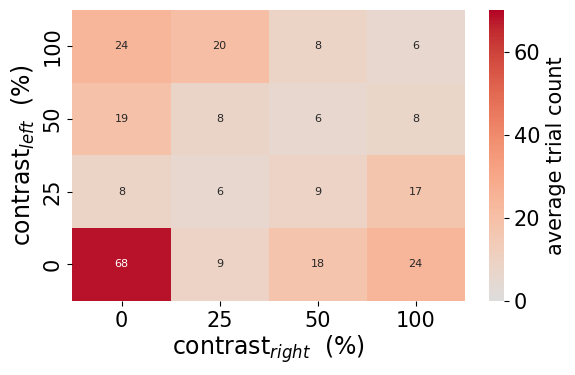

In [27]:
# @title Counts averaging
#sum counts per stimComb by session
sum_total_count=np.zeros((len(unique_stim_r),len(unique_stim_l)))
for ses in range(len(ses_total_count)):
  temp0 = np.where(ses_total_count[ses]==np.max(ses_total_count[ses]))[0].tolist()
  temp1 = np.where(ses_total_count[ses]==np.max(ses_total_count[ses]))[1].tolist()
  sum_total_count += ses_total_count[ses]
#average by mouse
avg_total_count = sum_total_count / len(ses_total_count)
#plot heatmap
avg_total_count_pd = pd.DataFrame(avg_total_count)
plt.figure()
sns.heatmap(avg_total_count_pd, annot=True, annot_kws={"size": 8}, fmt='.0f', cmap="coolwarm", \
  center=0, xticklabels=[0,25,50,100], yticklabels=[100,50,25,0], vmin=0, vmax=70,\
  cbar_kws={'label': 'average trial count'})
plt.xlabel('contrast$_{right}$  (%)', fontsize=17, labelpad=2)
plt.ylabel('contrast$_{left}$  (%)', fontsize=17, labelpad=4)

#thus, for most sessions, the maximum trial count falls in stimComb(0,0)

## Result: Psychometric

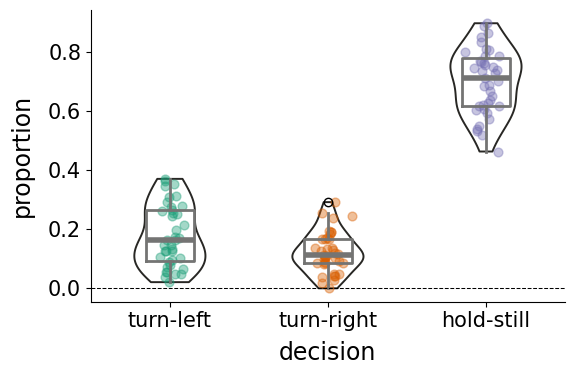

In [28]:
# @title Decision probabilities: with stimComb(0,0), indipendent of prior
#newDict['resp']: which side the response was (-1, 0, 1). 
#                 When the right-side stimulus had higher contrast, the correct choice was -1. 
#                 0 is a no go response.
from matplotlib.lines import lineStyles


p_turn_left=list()
p_turn_right=list()
p_hold_still=list()
for ses in range(len(newDict['name'])): # per session
  comb_index=list()
  temp_comb_00 = newDict['comb_index'][ses][index_comb_00[0]]
  temp_resp = []
  for idx in range(len(temp_comb_00)): # per trials
    temp_resp += [newDict['resp'][ses][temp_comb_00[idx]]]
  len_turn_left = len(np.where(np.array(temp_resp)==-1)[0])
  p_turn_left.append(len_turn_left/len(temp_resp))
  len_turn_right = len(np.where(np.array(temp_resp)==1)[0])
  p_turn_right.append(len_turn_right/len(temp_resp))
  len_hold_still = len(np.where(np.array(temp_resp)==0)[0])
  p_hold_still.append(len_hold_still/len(temp_resp))


#static parameters
POSITIONS = [0,1,2]
GREY_DARK = '#747473'
BLACK = '#282724'
COLOR_SCALE = ['#1B9E77','#D95F02','#7570B3']
medianprops = dict(linewidth=4, color=GREY_DARK, solid_capstyle='butt')
boxprops = dict(linewidth=2, color=GREY_DARK)
decision = ['turn-left', 'turn-right', 'hold-still']
xlabels = [f"{dec}" for i, dec in enumerate(decision)]

#data for ploting
jitter=0.04
x_data = [np.ones(len(newDict['name']))*0, np.ones(len(newDict['name']))*1, np.ones(len(newDict['name']))*2]
x_jittered = [x + st.t(df=8, scale=jitter).rvs(len(x)) for x in x_data]
y_data = [p_turn_left,p_turn_right,p_hold_still]

#plots
fig, ax = plt.subplots()
#violins
violins = ax.violinplot(y_data, positions=POSITIONS, widths=0.45, showextrema=False)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
#supervised boxes
ax.boxplot(y_data, positions=POSITIONS, showfliers=True, showcaps=False,\
            medianprops=medianprops, whiskerprops=boxprops, boxprops=boxprops)
#supervised scatters
for x, y, color in zip([x_jittered[0],x_jittered[1],x_jittered[2]], [p_turn_left,p_turn_right,p_hold_still], COLOR_SCALE):
    ax.scatter(x, y, s=40, color=color, alpha=0.4)

ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, ha='center', ma='center')
ax.set_xlabel('decision', fontsize=17, labelpad=7)
ax.set_ylabel('proportion', fontsize=17, labelpad=10)
#ax.set_ylabel('probability', fontsize=17, labelpad=10)
temp_xlim = plt.xlim()
ax.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), 'k', linestyle='--', linewidth=0.75) # add a reference line


In [29]:
# @title Dict supplement: previous indexes of stimComb(0,0)
temp_comb_index = []
newDict.update({'comb00_p1_idx':temp_comb_index})
for ses in range(len(newDict['name'])):
  comb_index = list()
  temp_comb_00 = newDict['comb_index'][ses][index_comb_00[0]]
  temp_comb_00p1 = temp_comb_00 - 1 
  # ↑ this is the prior trial list of stimComb(0,0) trials from the 1st session
  # no worry abt '-1' index, because it won't be found in the original list
  
  for comb in range(len(newDict['comb_index'][ses])): # search the index in 16 stimCombs
    a = []
    for idx in range(len(temp_comb_00p1)):
      temp = newDict['comb_index'][ses][comb]==temp_comb_00p1[idx]
      #highlight the identical indexes, but pale the others
      if sum(temp):
        a += [1]
      else:
        a += [0]
    temp_comb = (temp_comb_00p1 + 1) * a
    # ↑ +1 so that index '0' (if any) won't be wiped out
    temp_comb = temp_comb[temp_comb>0] - 1
    # ↑ then -1 to correct
    comb_index.append(temp_comb) #trials belonging to specific stimComb

  temp_comb_index = newDict['comb00_p1_idx']
  temp_comb_index.append(comb_index)
  newDict['comb00_p1_idx'] = temp_comb_index # key-value: session-#comb00_prior_trial_per_stimComb


In [30]:
# @title Result: proportion differences for stimulus-specific priors
avg_p_lhp_L = list()
avg_p_lhp_R = list()
avg_p_rhp_L = list()
avg_p_rhp_R = list()
diff_pLR = list()
diff_pRL = list()
for ses in range(len(newDict['comb00_p1_idx'])):
    pCho_L = 0
    pCho_R = 0
    for i in range(len(index_comb_Lr)):
        temp = newDict['comb00_p1_idx'][ses][index_comb_Lr[i]]
        temp_resp = []
        for idx in range(len(temp)):
            #temp_resp += [newDict['resp'][ses][temp[idx]]] # is this what you want ? this is the resp in prev trial !
            temp_resp += [newDict['resp'][ses][temp[idx]+1]] # +1 then that should be correct

        if len(temp)==0:
            pCho_L += 0
            pCho_R += 0
        else:
            pCho_L += np.sum(temp_resp==np.ones(len(temp_resp)))/len(temp)
            pCho_R += np.sum(temp_resp==np.ones(len(temp_resp))*-1)/len(temp)
    avg_p_lhp_L.append(pCho_L/len(index_comb_Lr))
    avg_p_lhp_R.append(pCho_R/len(index_comb_Lr))
    diff_pLR.append(avg_p_lhp_L[-1] - avg_p_lhp_R[-1])

    pCho_L = 0
    pCho_R = 0
    #print("choice probabilities, after rhp")
    for i in range(len(index_comb_lR)):
        temp = newDict['comb00_p1_idx'][ses][index_comb_lR[i]]
        temp_resp = []
        for idx in range(len(temp)):
            #temp_resp += [newDict['resp'][ses][temp[idx]]]
            temp_resp += [newDict['resp'][ses][temp[idx]+1]] # +1 then that should be correct

        if len(temp)==0:
            pCho_L += 0
            pCho_R += 0
        else:
            #NOTE: for correct resp, 
            # 1 means left-higher comb and turning right, 
            # -1 means right-higher comb and turning left.
            pCho_L += np.sum(temp_resp==np.ones(len(temp_resp)))/len(temp)
            pCho_R += np.sum(temp_resp==np.ones(len(temp_resp))*-1)/len(temp)
    avg_p_rhp_L.append(pCho_L/len(index_comb_lR))
    avg_p_rhp_R.append(pCho_R/len(index_comb_lR))
    diff_pRL.append(avg_p_rhp_R[-1] - avg_p_rhp_L[-1])


In [31]:
tstatrel_lhp, prel_value_lhp = stats.ttest_rel(avg_p_lhp_L, avg_p_lhp_R)  
tstatrel_rhp, prel_value_rhp = stats.ttest_rel(avg_p_rhp_L, avg_p_rhp_R)  
print('t-statistic: lhp, %.1f; rhp, %.1f'%(tstatrel_lhp,tstatrel_rhp))
print('p-value: lhp, %.3f; rhp, %.3f'%(prel_value_lhp,prel_value_rhp))
cirel_lhp = stats.ttest_rel(avg_p_lhp_L, avg_p_lhp_R).confidence_interval()
cirel_rhp = stats.ttest_rel(avg_p_rhp_L, avg_p_rhp_R).confidence_interval()
print('CI: lhp, [%.2f, %.2f]; rhp, [%.2f, %.2f]'\
      %(cirel_lhp[0],cirel_lhp[-1],cirel_rhp[0],cirel_rhp[-1]))
print('df: lhp, %i; rhp, %i'%(len(avg_p_lhp_L)-1,len(avg_p_rhp_L)-1))

t-statistic: lhp, -1.9; rhp, -0.7
p-value: lhp, 0.066; rhp, 0.484
CI: lhp, [-0.12, 0.00]; rhp, [-0.10, 0.05]
df: lhp, 38; rhp, 38


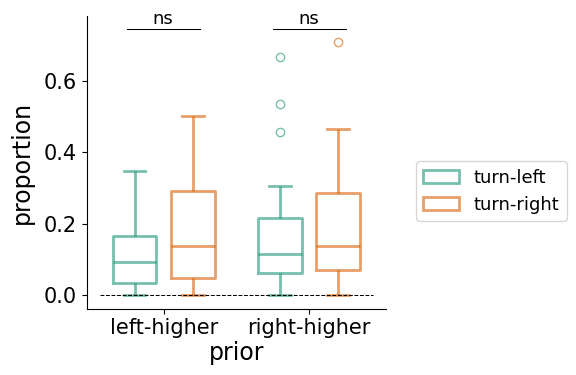

In [32]:
# @title Result: proportions of each turning decisions in each biasing prior
#NOTE: for each resp, 
# 1 means turning right, reporting a left-higher comb;  
# -1 means turning left, reporting a right-higher comb;
act_left = ['turn-left' for i in avg_p_lhp_L]
act_right = ['turn-right' for i in avg_p_lhp_R]
act = act_left + act_right
act += act

avg_p_lhp = avg_p_lhp_L + avg_p_lhp_R
avg_p_rhp = avg_p_rhp_L + avg_p_rhp_R
avg_p_xhp = avg_p_lhp + avg_p_rhp
prior_lhp = ['left-higher' for i in avg_p_lhp]
prior_rhp = ['right-higher' for i in avg_p_rhp]
PRIOR = prior_lhp + prior_rhp

avg_p_dict = {'proportion':avg_p_xhp, 'prior':PRIOR, 'resp':act}
#avg_p_dict = {'probability':avg_p_xhp, 'prior':PRIOR, 'resp':act}
avg_p_dict_pd = pd.DataFrame(data=avg_p_dict)

temp_COLOR_SCALE = [(0.1067,0.5882,0.4667,0.600), (0.8491,0.3734,0.0078,0.600)]


boxplot = sns.boxplot(data=avg_p_dict_pd, y='proportion', x='prior', hue='resp', \
#boxplot = sns.boxplot(data=avg_p_dict_pd, y='probability', x='prior', hue='resp', \
    palette=temp_COLOR_SCALE, fill=False, gap=.25, color='white', linewidth=2)
x = boxplot.get_xticks()
y = boxplot.get_ylim()
plt.plot([min(x)-0.25, min(x)+0.25],[max(y), max(y)], 'k', linewidth=0.75)
plt.plot([max(x)-0.25, max(x)+0.25],[max(y), max(y)], 'k', linewidth=0.75)
plt.legend(loc=(1.1,0.3), fontsize=13)
plt.text(min(x)-0.075, max(y)+0.015, 'ns', fontsize=13)
plt.text(max(x)-0.075, max(y)+0.015, 'ns', fontsize=13)
plt.xlabel('prior', fontsize=17, labelpad=2)
plt.ylabel('proportion', fontsize=17, labelpad=7)
#plt.ylabel('probability', fontsize=17, labelpad=7)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), \
        'k', linestyle='--', linewidth=0.75) # add a reference line

In [33]:
# @title Result: proportion differences for stimulus-specific priors
temp_len = [list(), list()] # 2 lists are enough, for left-higher & right-higher
count_L_lhp = list()
count_R_lhp = list()
count_L_rhp = list()
count_R_rhp = list()
for ses in range(len(newDict['comb00_p1_idx'])): # 39 sessions
    tempsum_len = [0, 0]
    count_L = 0
    count_R = 0
    for i in range(len(index_comb_Lr)): # 6 combs
        temp = newDict['comb00_p1_idx'][ses][index_comb_Lr[i]]
        tempsum_len[0] += len(temp)
        
        temp_resp = []
        for idx in range(len(temp)):
            temp_resp += [newDict['resp'][ses][temp[idx]+1]] # +1 then that should be correct

        if len(temp)==0:
            count_L += 0
            count_R += 0
        else:
            count_L += np.sum(temp_resp==np.ones(len(temp_resp)))
            count_R += np.sum(temp_resp==np.ones(len(temp_resp))*-1)
    count_L_lhp.append(count_L)
    count_R_lhp.append(count_R)
    temp_len[0].append(tempsum_len[0])

    count_L = 0
    count_R = 0
    for i in range(len(index_comb_lR)): # 6 combs
        temp = newDict['comb00_p1_idx'][ses][index_comb_lR[i]]
        tempsum_len[-1] += len(temp)

        temp_resp = []
        for idx in range(len(temp)): # trials
            temp_resp += [newDict['resp'][ses][temp[idx]+1]] # +1 then that should be correct

        if len(temp)==0:
            count_L += 0
            count_R += 0
        else:
            #NOTE: for correct resp, 
            # 1 means left-higher comb and turning right, 
            # -1 means right-higher comb and turning left.
            count_L += np.sum(temp_resp==np.ones(len(temp_resp)))
            count_R += np.sum(temp_resp==np.ones(len(temp_resp))*-1)
    count_L_rhp.append(count_L)
    count_R_rhp.append(count_R)
    temp_len[-1].append(tempsum_len[-1])


Text(0, 0.5, '$\\Delta$P$_{lhp}$')

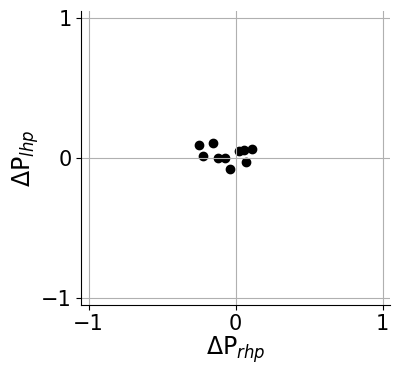

In [34]:
mou_len_L = list()
mou_count_L_lhp = list()
mou_count_L_rhp = list()
mou_len_R = list()
mou_count_R_lhp = list()
mou_count_R_rhp = list()
for mou in range(len(unique_name)): # per mouse
    mou_len_L.append(list())
    mou_len_R.append(list())
    mou_count_L_lhp.append(list())
    mou_count_L_rhp.append(list())
    mou_count_R_lhp.append(list())
    mou_count_R_rhp.append(list())
    for ses in range(len(newDict['name'])): # per session
        if newDict['name'][ses]==unique_name[mou]:
            mou_count_L_lhp[mou].append(count_L_lhp[ses])
            mou_count_L_rhp[mou].append(count_L_rhp[ses])
            mou_len_L[mou].append(temp_len[0][ses])
            mou_len_R[mou].append(temp_len[-1][ses])
            mou_count_R_lhp[mou].append(count_R_lhp[ses])
            mou_count_R_rhp[mou].append(count_R_rhp[ses])

moupool_len_L = list()
moupool_len_R = list()
moupool_count_L_lhp = list()
moupool_count_L_rhp = list()
moupool_count_R_lhp = list()
moupool_count_R_rhp = list()
for mou in range(len(unique_name)): # per mouse
    moupool_len_L.append(sum(mou_len_L[mou]))
    moupool_len_R.append(sum(mou_len_R[mou]))
    moupool_count_L_lhp.append(sum(mou_count_L_lhp[mou]))
    moupool_count_L_rhp.append(sum(mou_count_L_rhp[mou]))
    moupool_count_R_lhp.append(sum(mou_count_R_lhp[mou]))
    moupool_count_R_rhp.append(sum(mou_count_R_rhp[mou]))

dec_pp_L_lhp_mou = np.array(moupool_count_L_lhp)/np.array(moupool_len_L)
dec_pp_L_rhp_mou = np.array(moupool_count_L_rhp)/np.array(moupool_len_L)
diff1 = dec_pp_L_lhp_mou - dec_pp_L_rhp_mou
dec_pp_R_lhp_mou = np.array(moupool_count_R_lhp)/np.array(moupool_len_R)
dec_pp_R_rhp_mou = np.array(moupool_count_R_rhp)/np.array(moupool_len_R)
diff2 = dec_pp_R_rhp_mou - dec_pp_R_lhp_mou


#Figure
plt.figure(figsize=(4.25,4))
plt.scatter(diff1, diff2, color='k')
plt.ylim([-1.05,1.05])
plt.xlim([-1.05,1.05])
plt.xticks(np.arange(3)-1)
plt.yticks(np.arange(3)-1)
plt.grid(True)
plt.xlabel('$\Delta$P$_{rhp}$', fontsize=17, labelpad=0)
plt.ylabel('$\Delta$P$_{lhp}$', fontsize=17, labelpad=0)

In [35]:
# @title Result: proportion differences for decision-specific priors

# @title Dict supplement: previous indexes of stimComb(0,0)
temp_dec_index = []
newDict.update({'comb00_p1_dec_idx':temp_dec_index})
for ses in range(len(newDict['name'])):
  dec_index = list()
  temp_comb_00 = newDict['comb_index'][ses][index_comb_00[0]]
  temp_comb_00p1 = temp_comb_00 - 1 
  # ↑ this is the prior trial list of stimComb(0,0) trials from the 1st session
  temp_comb_00p1 = temp_comb_00p1[temp_comb_00p1>0] # make sure no '-1' index ...
  
  for dec in range(len(np.unique(newDict['resp'][ses]))): # search the index in 3 decisions 
    # [dec=0] resp=-1, turn left, right-higher/random-move
    # [dec=1] resp=0, hold still, no stim
    # [dec=2] resp=1, turn right, left-higher/random-move
    temp = np.unique(newDict['resp'][ses])[dec]==newDict['resp'][ses][temp_comb_00p1]
    temp_dec = (temp_comb_00p1 + 1) * temp
    # ↑ +1 so that index '0' (if any) won't be wiped out
    temp_dec = temp_dec[temp_dec>0] - 1
    # ↑ then -1 to correct
    dec_index.append(temp_dec) #trials belonging to specific stimComb

  temp_dec_index = newDict['comb00_p1_dec_idx']
  temp_dec_index.append(dec_index)
  newDict['comb00_p1_dec_idx'] = temp_dec_index # key-value: session-#comb00_prior_trial_per_stimComb


decavg_p_L = [list(), list(), list()]
decavg_p_R = [list(), list(), list()]
decdiff_pLR = [list(), list(), list()]
for ses in range(len(newDict['comb00_p1_dec_idx'])):
    pCho_L = 0
    pCho_R = 0
    for dec in range(len(np.unique(newDict['resp'][ses]))):
        if np.unique(newDict['resp'][ses])[dec]!=0:
            #if np.unique(newDict['resp'][ses])[dec]==-1, mouse experienced left-turn prior;
            #if np.unique(newDict['resp'][ses])[dec]==1, mouse experienced right-turn prior.
            temp = newDict['comb00_p1_dec_idx'][ses][dec]
            temp_resp = []
            for idx in range(len(temp)):
                temp_resp += [newDict['resp'][ses][temp[idx]+1]] # +1 then that should be correct

            if len(temp)==0:
                decavg_p_L[dec].append([0])
                decavg_p_R[dec].append([0])
            else:
                decavg_p_L[dec].append(np.sum(temp_resp==np.ones(len(temp_resp)))/len(temp_resp))
                decavg_p_R[dec].append(np.sum(temp_resp==np.ones(len(temp_resp))*-1)/len(temp_resp))
            decdiff_pLR[dec].append(decavg_p_L[dec][-1] - decavg_p_R[dec][-1])


# 'decdiff_pLR[0] > 0' indicates the 'turn_left' decision in previous trial attracted mouse's current decision
# ie the mouse prefers making a 'turn_left' decision after making a 'turn_left' decision

# similarly, 'decdiff_pLR[-1] < 0' also indicates an attraction from the previous trial
# but after making a 'turn_right' decison

# data points centering around the origin suggests there's no aggregate biasing effect

In [36]:
tstatrel_lhp, prel_value_lhp = stats.ttest_rel(decavg_p_L[0],decavg_p_R[0])
tstatrel_rhp, prel_value_rhp = stats.ttest_rel(decavg_p_L[-1],decavg_p_R[-1])
print('t-statistic: lhp, %.1f; rhp, %.1f'%(tstatrel_lhp,tstatrel_rhp))
print('p-value: lhp, %.3f; rhp, %.3f'%(prel_value_lhp,prel_value_rhp))
cirel_lhp = stats.ttest_rel(decavg_p_L[0], decavg_p_R[0]).confidence_interval()
cirel_rhp = stats.ttest_rel(decavg_p_L[-1], decavg_p_R[-1]).confidence_interval()
print('CI: lhp, [%.2f, %.2f]; rhp, [%.2f, %.2f]'\
      %(cirel_lhp[0],cirel_lhp[-1],cirel_rhp[0],cirel_rhp[-1]))
print('df: lhp, %i; rhp, %i'%(len(decavg_p_L[0])-1,len(decavg_p_L[-1])-1))

t-statistic: lhp, -0.5; rhp, -2.6
p-value: lhp, 0.655; rhp, 0.013
CI: lhp, [-0.08, 0.05]; rhp, [-0.14, -0.02]
df: lhp, 38; rhp, 38


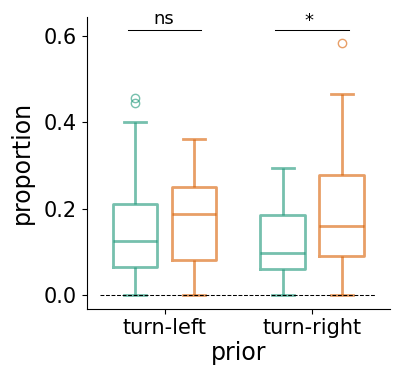

In [37]:
# @title Result: proportions of each turning decisions in each TURNED prior
#NOTE: for each resp, 
# 1 means turning right, reporting a left-higher comb;  
# -1 means turning left, reporting a right-higher comb;

avg_p_tl = decavg_p_L[0] + decavg_p_R[0]
avg_p_tr = decavg_p_L[-1] + decavg_p_R[-1]
avg_p_tx = avg_p_tl + avg_p_tr
prior_tl = ['turn-left' for i in avg_p_tl]
prior_tr = ['turn-right' for i in avg_p_tr]
PRIOR = prior_tl + prior_tr

avg_p_t_dict = {'proportion':avg_p_tx, 'prior':PRIOR, 'resp':act}
#avg_p_t_dict = {'probability':avg_p_tx, 'prior':PRIOR, 'resp':act}
avg_p_t_dict_pd = pd.DataFrame(data=avg_p_t_dict)

plt.figure(figsize=(4.25,4))
boxplot_t = sns.boxplot(data=avg_p_t_dict_pd, y='proportion', x='prior', hue='resp', \
#boxplot_t = sns.boxplot(data=avg_p_t_dict_pd, y='probability', x='prior', hue='resp', \
    palette=temp_COLOR_SCALE, fill=False, gap=.25, color='white', linewidth=2,legend=False)
x = boxplot_t.get_xticks()
y = boxplot_t.get_ylim()
plt.plot([min(x)-0.25, min(x)+0.25],[max(y), max(y)], 'k', linewidth=0.75)
plt.plot([max(x)-0.25, max(x)+0.25],[max(y), max(y)], 'k', linewidth=0.75)
#plt.legend(loc=(1.1,0.3), fontsize=13)
plt.text(min(x)-0.075, max(y)+0.015, 'ns', fontsize=13)
plt.text(max(x)-0.05, max(y)+0.01, '*', fontsize=13)
plt.xlabel('prior', fontsize=17, labelpad=2)
plt.ylabel('proportion', fontsize=17, labelpad=7)
#plt.ylabel('probability', fontsize=17, labelpad=7)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), \
        'k', linestyle='--', linewidth=0.75) # add a reference line

Text(0, 0.5, '$\\Delta$P$_{trp}$')

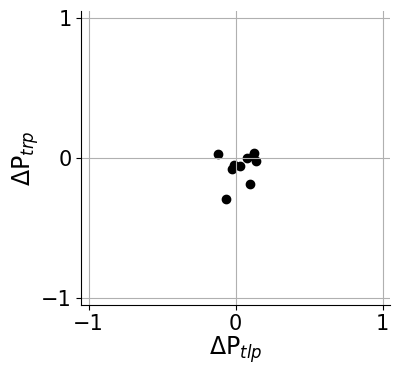

In [38]:
# **Pool same mouse's data together !**

# Result: proportion differences for decision-specific priors

temp_len = [list(), list(), list()]
temp_decavg_p_L = [list(), list(), list()]
temp_decavg_p_R = [list(), list(), list()]
for ses in range(len(newDict['comb00_p1_dec_idx'])):
    pCho_L = 0
    pCho_R = 0
    for dec in range(len(np.unique(newDict['resp'][ses]))): # [-1, 0, 1]
        if np.unique(newDict['resp'][ses])[dec]!=0:
            #if np.unique(newDict['resp'][ses])[dec]==-1, mouse experienced left-turn prior;
            #if np.unique(newDict['resp'][ses])[dec]==1, mouse experienced right-turn prior.
            temp_idx_list = newDict['comb00_p1_dec_idx'][ses][dec]
            temp_len[dec].append(len(temp_idx_list))
            temp_resp = []
            for idx in range(len(temp_idx_list)):
                temp_resp += [newDict['resp'][ses][temp_idx_list[idx]+1]] # +1 then that should be correct

            if len(temp_idx_list)==0:
                temp_decavg_p_L[dec].append([0])
                temp_decavg_p_R[dec].append([0])
            else:
                temp_decavg_p_L[dec].append(np.sum(temp_resp==np.ones(len(temp_resp))))
                temp_decavg_p_R[dec].append(np.sum(temp_resp==np.ones(len(temp_resp))*-1))


temptemp_len_L = [list(), list(), list(), list(), list(),\
                    list(), list(), list(), list(), list()]
temp_mou_dec_p_L_lhp = [list(), list(), list(), list(), list(),\
                    list(), list(), list(), list(), list()]
temp_mou_dec_p_L_rhp = [list(), list(), list(), list(), list(),\
                    list(), list(), list(), list(), list()]
temptemp_len_R = [list(), list(), list(), list(), list(),\
                    list(), list(), list(), list(), list()]
temp_mou_dec_p_R_lhp = [list(), list(), list(), list(), list(),\
                    list(), list(), list(), list(), list()]
temp_mou_dec_p_R_rhp = [list(), list(), list(), list(), list(),\
                    list(), list(), list(), list(), list()]
for mou in range(len(unique_name)):
    for ses in range(len(newDict['name'])):
        if newDict['name'][ses]==unique_name[mou]:
            temp_mou_dec_p_L_lhp[mou].append(temp_decavg_p_L[0][ses])
            temp_mou_dec_p_L_rhp[mou].append(temp_decavg_p_L[-1][ses])
            temptemp_len_L[mou].append(temp_len[0][ses])
            temptemp_len_R[mou].append(temp_len[-1][ses])
            temp_mou_dec_p_R_lhp[mou].append(temp_decavg_p_R[0][ses])
            temp_mou_dec_p_R_rhp[mou].append(temp_decavg_p_R[-1][ses])

len_mou_L = list()
dec_p_L_lhp_mou = list()
dec_p_L_rhp_mou = list()
len_mou_R = list()
dec_p_R_lhp_mou = list()
dec_p_R_rhp_mou = list()
for mou in range(len(unique_name)):
    len_mou_L.append(sum(temptemp_len_L[mou]))
    dec_p_L_lhp_mou.append(sum(temp_mou_dec_p_L_lhp[mou]))
    dec_p_L_rhp_mou.append(sum(temp_mou_dec_p_L_rhp[mou]))
    len_mou_R.append(sum(temptemp_len_R[mou]))
    dec_p_R_lhp_mou.append(sum(temp_mou_dec_p_R_lhp[mou]))
    dec_p_R_rhp_mou.append(sum(temp_mou_dec_p_R_rhp[mou]))

dec_pp_L_lhp_mou = np.array(dec_p_L_lhp_mou)/np.array(len_mou_L)
dec_pp_L_rhp_mou = np.array(dec_p_L_rhp_mou)/np.array(len_mou_L)
diff1 = dec_pp_L_lhp_mou - dec_pp_L_rhp_mou
dec_pp_R_lhp_mou = np.array(dec_p_R_lhp_mou)/np.array(len_mou_R)
dec_pp_R_rhp_mou = np.array(dec_p_R_rhp_mou)/np.array(len_mou_R)
diff2 = dec_pp_R_rhp_mou - dec_pp_R_lhp_mou


#Figure
plt.figure(figsize=(4.25,4))
plt.scatter(diff1, diff2, color='k')
plt.ylim([-1.05,1.05])
plt.xlim([-1.05,1.05])
plt.xticks(np.arange(3)-1)
plt.yticks(np.arange(3)-1)
plt.grid(True)
plt.xlabel('$\Delta$P$_{tlp}$', fontsize=17, labelpad=0)
plt.ylabel('$\Delta$P$_{trp}$', fontsize=17, labelpad=0)


## Result: Modeling

### GLM

#### per session

#### per mouse

In [39]:
mou_currC_L = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_currC_R = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_prevC_L = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_prevC_R = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_currD = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_prevD = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_prevRw = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
for mou in range(len(unique_name)):
    for ses in range(len(newDict['name'])):
        if newDict['name'][ses]==unique_name[mou]:
            mou_currC_L[mou] = np.vstack((mou_currC_L[mou],newDict['stim_l'][ses][1:].reshape(len(newDict['stim_l'][ses][1:]),1)))
            mou_currC_R[mou] = np.vstack((mou_currC_R[mou],newDict['stim_r'][ses][1:].reshape(len(newDict['stim_r'][ses][1:]),1)))
            mou_prevC_L[mou] = np.vstack((mou_prevC_L[mou],newDict['stim_l'][ses][:-1].reshape(len(newDict['stim_l'][ses][:-1]),1)))
            mou_prevC_R[mou] = np.vstack((mou_prevC_R[mou],newDict['stim_r'][ses][:-1].reshape(len(newDict['stim_r'][ses][:-1]),1)))
            mou_currD[mou] = np.vstack((mou_currD[mou],newDict['resp'][ses][1:].reshape(len(newDict['resp'][ses][1:]),1)))
            mou_prevD[mou] = np.vstack((mou_prevD[mou],newDict['resp'][ses][:-1].reshape(len(newDict['resp'][ses][:-1]),1)))
            mou_prevRw[mou] = np.vstack((mou_prevRw[mou],newDict['reward'][ses][:-1].reshape(len(newDict['reward'][ses][:-1]),1)))
    for trial in np.where(mou_prevRw[mou]==-1)[0]:
        mou_prevRw[mou][trial] = 0

#twist for model
#decision        
mou_currD_L = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_currD_H = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_currD_R = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_prevD_L = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_prevD_H = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
mou_prevD_R = [np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1), np.array([]).reshape(0,1), np.array([]).reshape(0,1), 
                np.array([]).reshape(0,1)]
for mou in range(len(unique_name)):       
    mou_currD_L[mou] = np.zeros_like(mou_currD[mou])
    temp_L_list = np.where(mou_currD[mou]==-1)[0]
    for i in range(len(temp_L_list)):
        mou_currD_L[mou][temp_L_list[i]] = mou_currD_L[mou][temp_L_list[i]]+1
    mou_currD_H[mou] = np.zeros_like(mou_currD[mou])
    temp_H_list = np.where(mou_currD[mou]==0)[0]
    for i in range(len(temp_H_list)):
        mou_currD_H[mou][temp_H_list[i]] = mou_currD_H[mou][temp_H_list[i]]+1
    mou_currD_R[mou] = np.zeros_like(mou_currD[mou])
    temp_R_list = np.where(mou_currD[mou]==1)[0]
    for i in range(len(temp_R_list)):
        mou_currD_R[mou][temp_R_list[i]] = mou_currD_R[mou][temp_R_list[i]]+1
    mou_prevD_L[mou] = np.zeros_like(mou_prevD[mou])
    temp_L_list = np.where(mou_prevD[mou]==-1)[0]
    for i in range(len(temp_L_list)):
        mou_prevD_L[mou][temp_L_list[i]] = mou_prevD_L[mou][temp_L_list[i]]+1
    mou_prevD_H[mou] = np.zeros_like(mou_prevD[mou])
    temp_H_list = np.where(mou_prevD[mou]==0)[0]
    for i in range(len(temp_H_list)):
        mou_prevD_H[mou][temp_H_list[i]] = mou_prevD_H[mou][temp_H_list[i]]+1
    mou_prevD_R[mou] = np.zeros_like(mou_prevD[mou])
    temp_R_list = np.where(mou_prevD[mou]==1)[0]
    for i in range(len(temp_R_list)):
        mou_prevD_R[mou][temp_R_list[i]] = mou_prevD_R[mou][temp_R_list[i]]+1


### Tensorflow

#### per mouse

In [40]:
# for ref
unique_dec = np.unique(mou_currD[mou]) # dec==-1, left-turn; dec==1, right-turn.
print('unique decision:\n',unique_dec)
one_hot_dec = tf.keras.utils.to_categorical(np.unique(mou_currD[mou]), num_classes=len(unique_dec))
print('\ncorresponding decision in one-hot encoding:\n',one_hot_dec,'\n')
print('corresponding index:')
for i in range(len(unique_dec)):
    print(np.where(one_hot_dec[i])[0])

unique decision:
 [-1.  0.  1.]

corresponding decision in one-hot encoding:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]] 

corresponding index:
[2]
[0]
[1]


##### Twist 1 - Encoding prevD as -1/0/1

In [41]:
pred_reg_prevD = list()
class_pred_reg_prevD = list()
mou_weights_reg_prevD = list()
mou_accuracy_reg_prevD = list()
for mou in range(len(unique_name)):
    print("\n** ",unique_name[mou],":")
    num_classes = len(np.unique(mou_currD[mou]))
    one_hot_currD = tf.keras.utils.to_categorical(mou_currD[mou], num_classes=num_classes)
    #one_hot_prevD = tf.keras.utils.to_categorical(mou_prevD[mou], num_classes=num_classes)
    #X = np.hstack([mou_currC_L[mou],mou_currC_R[mou],mou_prevC_L[mou],mou_prevC_R[mou],one_hot_prevD])
    X = np.hstack([mou_currC_L[mou],mou_currC_R[mou],mou_prevC_L[mou],mou_prevC_R[mou],mou_prevD[mou]])
    input_num = np.size(X,axis=1)
    #build model
    model = Sequential() # Create a softmax regression model
    model.add(Dense(num_classes, input_dim=input_num, activation='softmax')) # Add the softmax output layer directly
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model

    history = model.fit(X, one_hot_currD, epochs=1000, batch_size=128, verbose=0) # Train the model with one-hot encoded labels
    mou_accuracy_reg_prevD.append(history.history['accuracy'][-1]) # Retrieve the accuracy values from the history and pick the latest one
    pred_reg_prevD.append(model.predict(X)) # Make predictions
    class_pred_reg_prevD.append(np.argmax(pred_reg_prevD[-1], axis=1)) # Convert softmax output to class predictions

    # Access and print the weights of each layer
    for layer in model.layers:
        mou_weights_reg_prevD.append(layer.get_weights())
        for i, weights in enumerate(layer.get_weights()):
            print(f"Weights {i + 1} shape:", weights.shape)
            print(weights)


**  Cori :




22/22 [==============================] - 0s 1ms/step
Weights 1 shape: (5, 3)
[[-1.3685634   2.4968824  -1.0805308 ]
 [-0.9302372  -1.4358059   1.5226922 ]
 [-0.28891835 -0.5571578   0.5817816 ]
 [ 0.6529461   0.75284946 -0.9329685 ]
 [ 0.10020486  0.28103063 -0.5351362 ]]
Weights 2 shape: (3,)
[ 0.6286734  -0.5979739  -0.17311646]

**  Forssmann :
33/33 [==============================] - 0s 713us/step
Weights 1 shape: (5, 3)
[[-1.5166293   1.6202487  -1.976538  ]
 [-1.7671759  -2.5317855   1.844522  ]
 [ 0.03546292 -0.57831913 -0.49263012]
 [-0.01182454  0.64936393  0.42154652]
 [-0.01731853  0.22447985  0.1100622 ]]
Weights 2 shape: (3,)
[ 0.7988655 -0.6751101 -0.2506102]

**  Hench :
44/44 [==============================] - 0s 693us/step
Weights 1 shape: (5, 3)
[[-1.6402229   1.4218996  -2.9925    ]
 [-1.7026904  -2.3735228   1.3985177 ]
 [ 0.44789428 -0.73731947  1.5345122 ]
 [ 0.16853313  0.57989025 -0.3943124 ]
 [ 0.12735105  0.44597962 -0.14513372]]
Weights 2 shap

In [42]:
moutf_res_L_params_enco = np.array([])
moutf_res_H_params_enco = np.array([])
moutf_res_R_params_enco = np.array([])
for mou in range(len(unique_name)):
    temp_L_params=list()
    temp_L_params.append(mou_weights_reg_prevD[mou][1][2]) 
    # '[1]' marks the internal-bias weights, '[2]' marks the left-turn dec
    temp_H_params=list()
    temp_H_params.append(mou_weights_reg_prevD[mou][1][0]) 
    # '[1]' marks the internal-bias weights, '[0]' marks the hold-still dec
    temp_R_params=list()
    temp_R_params.append(mou_weights_reg_prevD[mou][1][1]) 
    # 1st '[1]' marks the internal-bias weights, 2nd '[1]' marks the right-turn dec
    for param in range(input_num):
        temp_L_params.append(mou_weights_reg_prevD[mou][0][param][2]) 
        # '[0]' marks the experiment-related weights, '[2]' marks the left-turn dec
        temp_H_params.append(mou_weights_reg_prevD[mou][0][param][0]) 
        # 1st '[0]' marks the experiment-related weights, 2nd '[0]' marks the hold-still dec
        temp_R_params.append(mou_weights_reg_prevD[mou][0][param][1]) 
        # '[0]' marks the experiment-related weights, '[1]' marks the right-turn dec
    temptemp_L_params = np.array(temp_L_params).reshape(1,len(temp_L_params))
    temptemp_H_params = np.array(temp_H_params).reshape(1,len(temp_H_params))
    temptemp_R_params = np.array(temp_R_params).reshape(1,len(temp_R_params))
    if mou:
        moutf_res_L_params_enco = np.vstack((moutf_res_L_params_enco, temptemp_L_params))
        moutf_res_H_params_enco = np.vstack((moutf_res_H_params_enco, temptemp_H_params))
        moutf_res_R_params_enco = np.vstack((moutf_res_R_params_enco, temptemp_R_params))
    else:
        moutf_res_L_params_enco = temptemp_L_params
        moutf_res_H_params_enco = temptemp_H_params
        moutf_res_R_params_enco = temptemp_R_params


In [88]:
tstat_tf_L_enco = [list(), list(), list(), list(), list(), list()]
p_value_tf_L_enco = [list(), list(), list(), list(), list(), list()]
tstat_tf_H_enco = [list(), list(), list(), list(), list(), list()]
p_value_tf_H_enco = [list(), list(), list(), list(), list(), list()]
tstat_tf_R_enco = [list(), list(), list(), list(), list(), list()]
p_value_tf_R_enco = [list(), list(), list(), list(), list(), list()]
feature_names=['internal-bias','currStim_L','currStim_R','prevStim_L','prevStim_R', 'prevDec']
for param in range(np.size(moutf_res_L_params_enco, axis=1)):
    # the last parameter from Theiler is an outlier, thus is removed below
    tstat_tf_L_enco[param], p_value_tf_L_enco[param] = stats.ttest_1samp(moutf_res_L_params_enco[:,param], popmean=0)
    tstat_tf_H_enco[param], p_value_tf_H_enco[param] = stats.ttest_1samp(moutf_res_H_params_enco[:,param], popmean=0)
    tstat_tf_R_enco[param], p_value_tf_R_enco[param] = stats.ttest_1samp(moutf_res_R_params_enco[:,param], popmean=0)
    print('\nparam: ', feature_names[param])
    print('t-statistic: turn-left, %.1f; hold-still, %.1f; turn-right, %.1f'
          %(tstat_tf_L_enco[param],tstat_tf_H_enco[param],tstat_tf_R_enco[param]))
    print('p-value: turn-left, %.3f; hold-still, %.3f; turn-right, %.3f'
          %(p_value_tf_L_enco[param],p_value_tf_H_enco[param],p_value_tf_R_enco[param]))


param:  internal-bias
t-statistic: turn-left, -3.2; hold-still, 12.0; turn-right, -5.8
p-value: turn-left, 0.010; hold-still, 0.000; turn-right, 0.000

param:  currStim_L
t-statistic: turn-left, -8.3; hold-still, -8.3; turn-right, 17.0
p-value: turn-left, 0.000; hold-still, 0.000; turn-right, 0.000

param:  currStim_R
t-statistic: turn-left, 15.0; hold-still, -10.5; turn-right, -11.2
p-value: turn-left, 0.000; hold-still, 0.000; turn-right, 0.000

param:  prevStim_L
t-statistic: turn-left, 3.6; hold-still, 1.6; turn-right, -8.5
p-value: turn-left, 0.006; hold-still, 0.146; turn-right, 0.000

param:  prevStim_R
t-statistic: turn-left, -2.7; hold-still, -0.3; turn-right, 7.9
p-value: turn-left, 0.023; hold-still, 0.765; turn-right, 0.000

param:  prevDec
t-statistic: turn-left, -3.3; hold-still, -1.9; turn-right, 1.1
p-value: turn-left, 0.009; hold-still, 0.087; turn-right, 0.313


(-3.761522054672241, 3.3914374351501464)

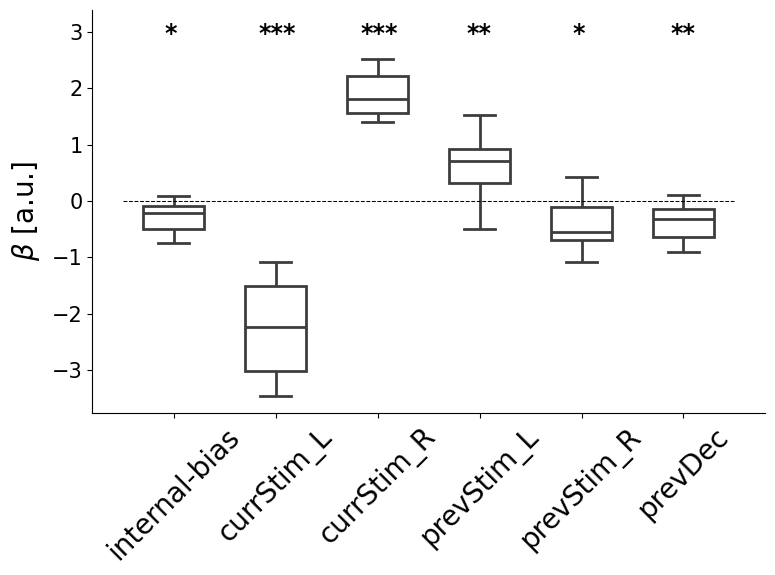

In [90]:
plt.figure(figsize=(8,6))
boxplot = sns.boxplot(data=moutf_res_L_params_enco, showfliers=False, gap=.25, color='white', linewidth=2)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), 'k', linestyle='--', linewidth=0.75) # add a reference line
#plt.title('TF: Turn-left _ per Mouse', fontweight='bold')

plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, fontsize=20)
plt.ylabel(r'$\beta$ [a.u.]', fontsize=20, labelpad=7)

x = boxplot.get_xticks()
y = boxplot.get_ylim()
for i in x:
    if p_value_tf_L_enco[i]<0.001:
        plt.text(i-0.17, max(y)+0.015, '***', fontsize=17, fontweight='bold')
    elif p_value_tf_L_enco[i]<0.01:
        plt.text(i-0.13, max(y)+0.015, '**', fontsize=17, fontweight='bold')
    elif p_value_tf_L_enco[i]<0.05:
        plt.text(i-0.09, max(y)+0.015, '*', fontsize=17, fontweight='bold')

plt.ylim([y[0], y[1]+y[1]*0.2])

(-2.2689277291297913, 1.2709864568710327)

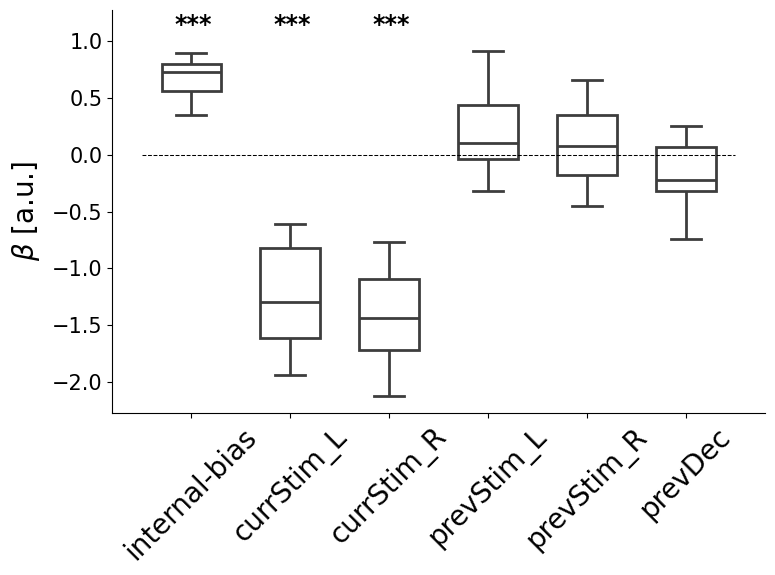

In [91]:
plt.figure(figsize=(8,6))
boxplot = sns.boxplot(data=moutf_res_H_params_enco, showfliers=False, gap=.25, color='white', linewidth=2)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), 'k', linestyle='--', linewidth=0.75) # add a reference line
#plt.title('TF: Hold-still _ per Mouse', fontweight='bold')

plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, fontsize=20)
plt.ylabel(r'$\beta$ [a.u.]', fontsize=20, labelpad=7)

x = boxplot.get_xticks()
y = boxplot.get_ylim()
for i in x:
    if p_value_tf_H_enco[i]<0.001:
        plt.text(i-0.17, max(y)+0.015, '***', fontsize=17, fontweight='bold')
    elif p_value_tf_H_enco[i]<0.01:
        plt.text(i-0.13, max(y)+0.015, '**', fontsize=17, fontweight='bold')
    elif p_value_tf_H_enco[i]<0.05:
        plt.text(i-0.09, max(y)+0.015, '*', fontsize=17, fontweight='bold')

plt.ylim([y[0], y[1]+y[1]*0.2])

(-2.785717856884003, 3.360953106880188)

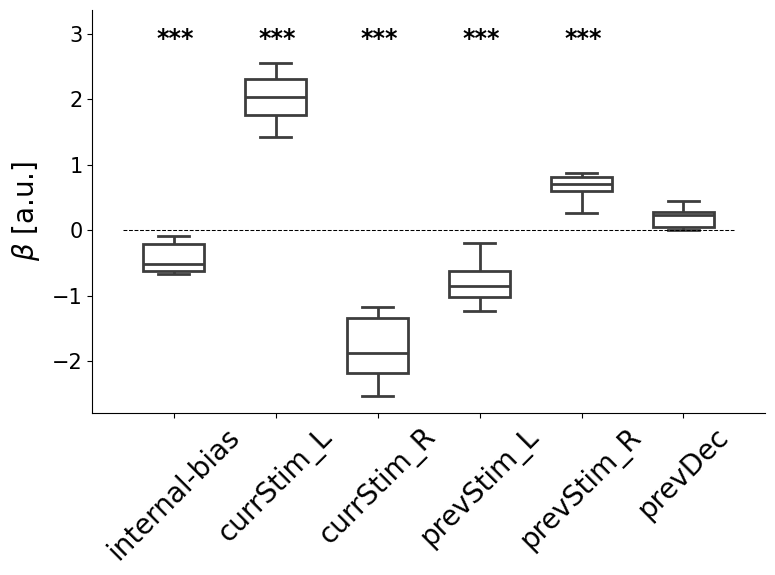

In [92]:
plt.figure(figsize=(8,6))
boxplot = sns.boxplot(data=moutf_res_R_params_enco, showfliers=False, gap=.25, color='white', linewidth=2)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), 'k', linestyle='--', linewidth=0.75) # add a reference line
#plt.title('TF: Turn-right _ per Mouse', fontweight='bold')

plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, fontsize=20)
plt.ylabel(r'$\beta$ [a.u.]', fontsize=20, labelpad=7)

x = boxplot.get_xticks()
y = boxplot.get_ylim()
for i in x:
    if p_value_tf_R_enco[i]<0.001:
        plt.text(i-0.17, max(y)+0.015, '***', fontsize=17, fontweight='bold')
    elif p_value_tf_R_enco[i]<0.01:
        plt.text(i-0.13, max(y)+0.015, '**', fontsize=17, fontweight='bold')
    elif p_value_tf_R_enco[i]<0.05:
        plt.text(i-0.09, max(y)+0.015, '*', fontsize=17, fontweight='bold')

plt.ylim([y[0], y[1]+y[1]*0.2])

##### Twist 2 - Transforming Stim with tanh (ref: Roy et al., 2021)  <based on Twist 1>

##### Twist 3 - prevStim->prevDeltaStim  <based on Twist 2>

##### Twist 4 - Feature: prevDec->prevRw <based on Twist 2>

In [47]:
#hyper = 5 # hyperparameter for stimulus transformation

pred_reg_rw = list()
class_pred_reg_rw = list()
mou_weights_reg_rw = list()
mou_accuracy_reg_rw = list()
for mou in range(len(unique_name)):
    print("\n** ",unique_name[mou],":")
    num_classes = len(np.unique(mou_currD[mou]))
    one_hot_currD = tf.keras.utils.to_categorical(mou_currD[mou], num_classes=num_classes)
    #one_hot_prevD = tf.keras.utils.to_categorical(mou_prevD[mou], num_classes=num_classes)
    #X = np.hstack([mou_currC_L[mou],mou_currC_R[mou],mou_prevC_L[mou],mou_prevC_R[mou],one_hot_prevD])
    X = np.hstack([mou_currC_L[mou],mou_currC_R[mou],mou_prevC_L[mou],mou_prevC_R[mou],mou_prevRw[mou]])
    #temp_currC_L = np.tanh(mou_currC_L[mou]*hyper) / np.tanh(hyper)
    #temp_currC_R = np.tanh(mou_currC_R[mou]*hyper) / np.tanh(hyper)
    #temp_prevC_L = np.tanh(mou_prevC_L[mou]*hyper) / np.tanh(hyper)
    #temp_prevC_R = np.tanh(mou_prevC_R[mou]*hyper) / np.tanh(hyper)
    #X = np.hstack([temp_currC_L,temp_currC_R,temp_prevC_L,temp_prevC_R,mou_prevRw[mou]])
    input_num = np.size(X,axis=1)
    #build model
    model = Sequential() # Create a softmax regression model
    model.add(Dense(num_classes, input_dim=input_num, activation='softmax')) # Add the softmax output layer directly
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model

    history = model.fit(X, one_hot_currD, epochs=1000, batch_size=128, verbose=0) # Train the model with one-hot encoded labels
    mou_accuracy_reg_rw.append(history.history['accuracy'][-1]) # Retrieve the accuracy values from the history and pick the latest one
    pred_reg_rw.append(model.predict(X)) # Make predictions
    class_pred_reg_rw.append(np.argmax(pred_reg_rw[-1], axis=1)) # Convert softmax output to class predictions

    # Access and print the weights of each layer
    for layer in model.layers:
        mou_weights_reg_rw.append(layer.get_weights())
        for i, weights in enumerate(layer.get_weights()):
            print(f"Weights {i + 1} shape:", weights.shape)
            print(weights)


**  Cori :
22/22 [==============================] - 0s 1ms/step
Weights 1 shape: (5, 3)
[[-1.9156079   1.7807285  -1.6334252 ]
 [-0.7164654  -1.0566133   1.5800841 ]
 [ 0.1154205  -0.11491558  0.16280039]
 [ 0.5423543   0.55315757 -0.35601565]
 [-0.88087255  0.1209674   0.4743994 ]]
Weights 2 shape: (3,)
[ 1.0133995  -0.80123127 -0.5543195 ]

**  Forssmann :
33/33 [==============================] - 0s 713us/step
Weights 1 shape: (5, 3)
[[-1.2911191   1.7625842  -1.9708487 ]
 [-1.4476153  -2.1174712   2.3424463 ]
 [ 0.7846213   0.5894353   0.49137694]
 [-0.14783207  0.08847117  0.03199631]
 [-0.89142305  0.22536597  1.0183109 ]]
Weights 2 shape: (3,)
[ 1.3872788 -0.8024255 -0.9825977]

**  Hench :
44/44 [==============================] - 0s 698us/step
Weights 1 shape: (5, 3)
[[-1.0579517   2.1560392  -2.0663075 ]
 [-1.703458   -2.0768316   1.6728723 ]
 [ 0.05807056 -0.82650185  0.5253414 ]
 [-0.18772781 -0.04126946 -0.13575216]
 [-1.520937    0.34056234  0.7622786 ]]
Weights 2 shape: (

In [48]:
moutf_res_L_params_rw = np.array([])
moutf_res_H_params_rw = np.array([])
moutf_res_R_params_rw = np.array([])
for mou in range(len(unique_name)):
    temp_L_params=list()
    temp_L_params.append(mou_weights_reg_rw[mou][1][2]) 
    # '[1]' marks the internal-bias weights, '[2]' marks the left-turn dec
    temp_H_params=list()
    temp_H_params.append(mou_weights_reg_rw[mou][1][0]) 
    # '[1]' marks the internal-bias weights, '[0]' marks the hold-still dec
    temp_R_params=list()
    temp_R_params.append(mou_weights_reg_rw[mou][1][1]) 
    # 1st '[1]' marks the internal-bias weights, 2nd '[1]' marks the right-turn dec
    for param in range(input_num): # b0 are in below; other parameters are in above
        temp_L_params.append(mou_weights_reg_rw[mou][0][param][2]) 
        # '[0]' marks the experiment-related weights, '[2]' marks the left-turn dec
        temp_H_params.append(mou_weights_reg_rw[mou][0][param][0]) 
        # 1st '[0]' marks the experiment-related weights, 2nd '[0]' marks the hold-still dec
        temp_R_params.append(mou_weights_reg_rw[mou][0][param][1]) 
        # '[0]' marks the experiment-related weights, '[1]' marks the right-turn dec
    temptemp_L_params = np.array(temp_L_params).reshape(1,len(temp_L_params))
    temptemp_H_params = np.array(temp_H_params).reshape(1,len(temp_H_params))
    temptemp_R_params = np.array(temp_R_params).reshape(1,len(temp_R_params))
    if mou:
        moutf_res_L_params_rw = np.vstack((moutf_res_L_params_rw, temptemp_L_params))
        moutf_res_H_params_rw = np.vstack((moutf_res_H_params_rw, temptemp_H_params))
        moutf_res_R_params_rw = np.vstack((moutf_res_R_params_rw, temptemp_R_params))
    else:
        moutf_res_L_params_rw = temptemp_L_params
        moutf_res_H_params_rw = temptemp_H_params
        moutf_res_R_params_rw = temptemp_R_params


In [77]:
tstat_tf_L_rw = [list(), list(), list(), list(), list(), list()]
p_value_tf_L_rw = [list(), list(), list(), list(), list(), list()]
tstat_tf_H_rw = [list(), list(), list(), list(), list(), list()]
p_value_tf_H_rw = [list(), list(), list(), list(), list(), list()]
tstat_tf_R_rw = [list(), list(), list(), list(), list(), list()]
p_value_tf_R_rw = [list(), list(), list(), list(), list(), list()]
feature_names=['internal-bias','currStim_L','currStim_R','prevStim_L','prevStim_R', 'prevRw']
for param in range(np.size(moutf_res_L_params_rw, axis=1)):
    # the last parameter from Theiler is an outlier, thus is removed below
    tstat_tf_L_rw[param], p_value_tf_L_rw[param] = stats.ttest_1samp(moutf_res_L_params_rw[:,param], popmean=0)
    tstat_tf_H_rw[param], p_value_tf_H_rw[param] = stats.ttest_1samp(moutf_res_H_params_rw[:,param], popmean=0)
    tstat_tf_R_rw[param], p_value_tf_R_rw[param] = stats.ttest_1samp(moutf_res_R_params_rw[:,param], popmean=0)
    print('\nparam: ', feature_names[param])
    print('t-statistic: turn-left, %.1f; hold-still, %.1f; turn-right, %.1f'
          %(tstat_tf_L_rw[param],tstat_tf_H_rw[param],tstat_tf_R_rw[param]))
    print('p-value: turn-left, %.3f; hold-still, %.3f; turn-right, %.3f'
          %(p_value_tf_L_rw[param],p_value_tf_H_rw[param],p_value_tf_R_rw[param]))


param:  internal-bias
t-statistic: turn-left, -5.1; hold-still, 14.4; turn-right, -7.0
p-value: turn-left, 0.001; hold-still, 0.000; turn-right, 0.000

param:  currStim_L
t-statistic: turn-left, -11.6; hold-still, -6.6; turn-right, 14.9
p-value: turn-left, 0.000; hold-still, 0.000; turn-right, 0.000

param:  currStim_R
t-statistic: turn-left, 18.3; hold-still, -10.0; turn-right, -13.7
p-value: turn-left, 0.000; hold-still, 0.000; turn-right, 0.000

param:  prevStim_L
t-statistic: turn-left, 3.0; hold-still, 3.1; turn-right, -2.4
p-value: turn-left, 0.015; hold-still, 0.012; turn-right, 0.037

param:  prevStim_R
t-statistic: turn-left, -3.9; hold-still, -0.0; turn-right, 2.7
p-value: turn-left, 0.003; hold-still, 0.963; turn-right, 0.025

param:  prevRw
t-statistic: turn-left, 7.7; hold-still, -8.6; turn-right, 4.5
p-value: turn-left, 0.000; hold-still, 0.000; turn-right, 0.002


(-3.0296109676361085, 3.2981464576721193)

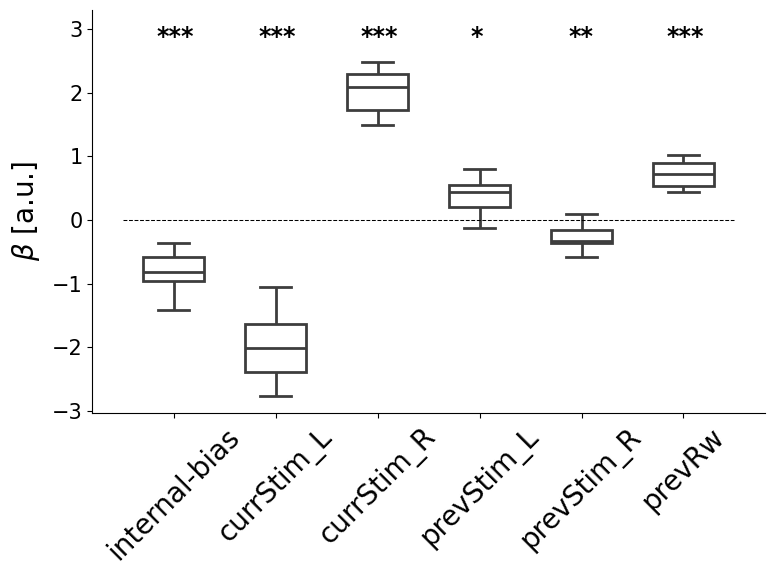

In [87]:
plt.figure(figsize=(8,6))
boxplot = sns.boxplot(data=moutf_res_L_params_rw, showfliers=False, gap=.25, color='white', linewidth=2)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), 'k', linestyle='--', linewidth=0.75) # add a reference line
#plt.title('TF: Turn-left _ per Mouse', fontweight='bold')

plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, fontsize=20)
plt.ylabel(r'$\beta$ [a.u.]', fontsize=20, labelpad=7)

x = boxplot.get_xticks()
y = boxplot.get_ylim()
for i in x:
    if p_value_tf_L_rw[i]<0.001:
        plt.text(i-0.17, max(y)+0.015, '***', fontsize=17, fontweight='bold')
    elif p_value_tf_L_rw[i]<0.01:
        plt.text(i-0.13, max(y)+0.015, '**', fontsize=17, fontweight='bold')
    elif p_value_tf_L_rw[i]<0.05:
        plt.text(i-0.09, max(y)+0.015, '*', fontsize=17, fontweight='bold')

plt.ylim([y[0], y[1]+y[1]*0.2])

(-2.3173121511936188, 2.532212483882904)

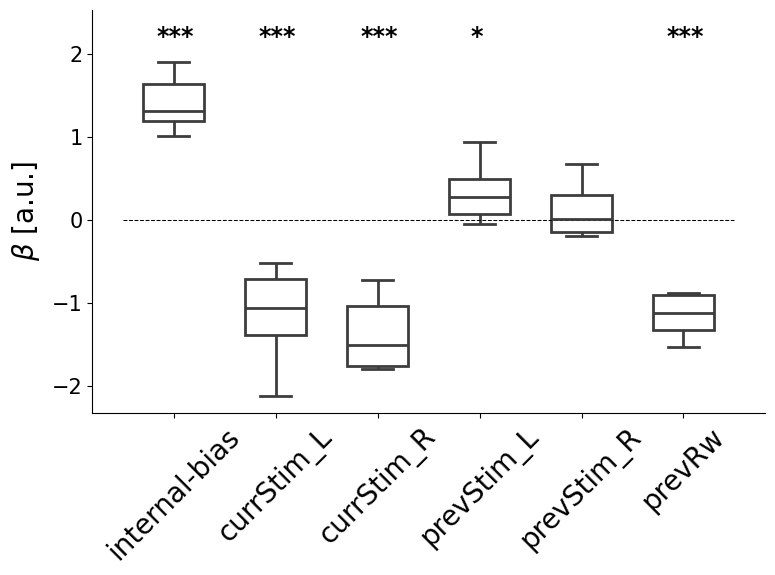

In [85]:
plt.figure(figsize=(8,6))
boxplot = sns.boxplot(data=moutf_res_H_params_rw, showfliers=False, gap=.25, color='white', linewidth=2)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), 'k', linestyle='--', linewidth=0.75) # add a reference line
#plt.title('TF: Hold-still _ per Mouse', fontweight='bold')

plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, fontsize=20)
plt.ylabel(r'$\beta$ [a.u.]', fontsize=20, labelpad=7)

x = boxplot.get_xticks()
y = boxplot.get_ylim()
for i in x:
    if p_value_tf_H_rw[i]<0.001:
        plt.text(i-0.17, max(y)+0.015, '***', fontsize=17, fontweight='bold')
    elif p_value_tf_H_rw[i]<0.01:
        plt.text(i-0.13, max(y)+0.015, '**', fontsize=17, fontweight='bold')
    elif p_value_tf_H_rw[i]<0.05:
        plt.text(i-0.09, max(y)+0.015, '*', fontsize=17, fontweight='bold')

plt.ylim([y[0], y[1]+y[1]*0.2])

(-2.37008650302887, 3.82493971824646)

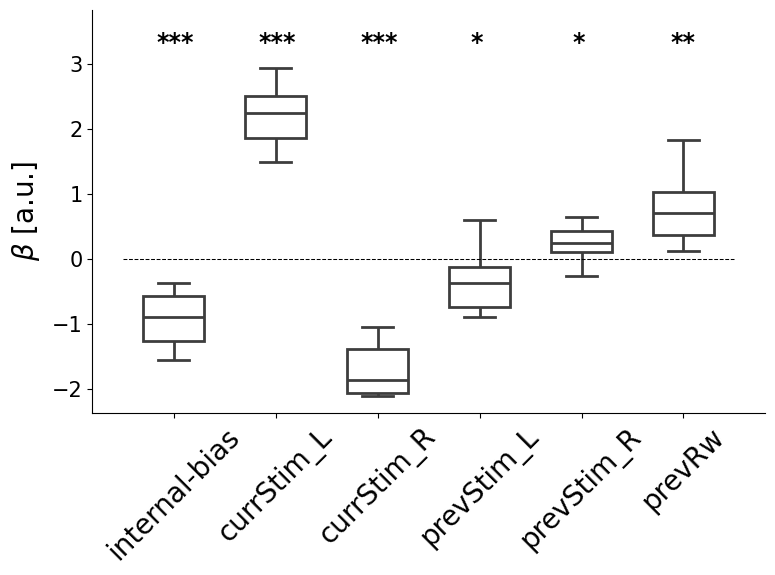

In [84]:
plt.figure(figsize=(8,6))
boxplot = sns.boxplot(data=moutf_res_R_params_rw, showfliers=False, gap=.25, color='white', linewidth=2)
temp_xlim = plt.xlim()
plt.plot(np.array(temp_xlim), np.zeros(len(np.array(temp_xlim))), 'k', linestyle='--', linewidth=0.75) # add a reference line
#plt.title('TF: Turn-right _ per Mouse', fontweight='bold')

plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, fontsize=20)
plt.ylabel(r'$\beta$ [a.u.]', fontsize=20, labelpad=7)

x = boxplot.get_xticks()
y = boxplot.get_ylim()
for i in x:
    if p_value_tf_R_rw[i]<0.001:
        plt.text(i-0.17, max(y)+0.015, '***', fontsize=17, fontweight='bold')
    elif p_value_tf_R_rw[i]<0.01:
        plt.text(i-0.13, max(y)+0.015, '**', fontsize=17, fontweight='bold')
    elif p_value_tf_R_rw[i]<0.05:
        plt.text(i-0.09, max(y)+0.015, '*', fontsize=17, fontweight='bold')

plt.ylim([y[0], y[1]+y[1]*0.2])

### Alternative Models - Model Comparison (BIC)

#### 1. no-history: beta0 + currStim <based on Twist 2>

In [93]:
hyper = 5 # hyperparameter for stimulus transformation

bic_altm1 = []
aic_altm1 = []
for mou in range(len(unique_name)):
    print("\n** ",unique_name[mou],":")
    num_classes = len(np.unique(mou_currD[mou]))
    one_hot_currD = tf.keras.utils.to_categorical(mou_currD[mou], num_classes=num_classes)
    #temp_currC_L = np.tanh(mou_currC_L[mou]*hyper) / np.tanh(hyper)
    #temp_currC_R = np.tanh(mou_currC_R[mou]*hyper) / np.tanh(hyper)
    X = np.hstack([mou_currC_L[mou],mou_currC_R[mou]])
    input_num = np.size(X,axis=1)
    #build model
    model = Sequential() # Create a softmax regression model
    model.add(Dense(num_classes, input_dim=input_num, activation='softmax')) # Add the softmax output layer directly
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model

    history = model.fit(X, one_hot_currD, epochs=1000, batch_size=128, verbose=0) # Train the model with one-hot encoded labels
    likelihood = -history.history['loss'][-1]
    num_parameters = np.sum([np.prod(variable.shape) for variable in model.trainable_variables])
    num_data_points = np.size(X,axis=0)
    bic_altm1.append(-2 * likelihood + num_parameters * np.log(num_data_points))
    aic_altm1.append(-2 * likelihood + num_parameters * 2)
    print(f'BIC: {bic_altm1[-1]}, AIC: {aic_altm1[-1]}')



**  Cori :
BIC: 60.587575180743315, AIC: 19.75735080242157

**  Forssmann :
BIC: 64.14200941270838, AIC: 19.610575795173645

**  Hench :
BIC: 66.88184628444576, AIC: 19.63891077041626

**  Lederberg :
BIC: 70.37000767017679, AIC: 19.416263937950134

**  Moniz :
BIC: 59.387025869635245, AIC: 19.769771099090576

**  Muller :
BIC: 61.57029694453687, AIC: 19.648197531700134

**  Radnitz :
BIC: 63.39070097919994, AIC: 19.616470456123352

**  Richards :
BIC: 64.8836426363847, AIC: 19.67782986164093

**  Tatum :
BIC: 63.14407220247756, AIC: 19.483407855033875

**  Theiler :
BIC: 54.05021217425863, AIC: 19.53691554069519


#### 2. stim-history: beta0 + currStim + prevStim <based on Twist 2>

In [94]:
hyper = 5 # hyperparameter for stimulus transformation

bic_altm2 = []
aic_altm2 = []
for mou in range(len(unique_name)):
    print("\n** ",unique_name[mou],":")
    num_classes = len(np.unique(mou_currD[mou]))
    one_hot_currD = tf.keras.utils.to_categorical(mou_currD[mou], num_classes=num_classes)
    #temp_currC_L = np.tanh(mou_currC_L[mou]*hyper) / np.tanh(hyper)
    #temp_currC_R = np.tanh(mou_currC_R[mou]*hyper) / np.tanh(hyper)
    #temp_prevC_L = np.tanh(mou_prevC_L[mou]*hyper) / np.tanh(hyper)
    #temp_prevC_R = np.tanh(mou_prevC_R[mou]*hyper) / np.tanh(hyper)
    #X = np.hstack([temp_currC_L,temp_currC_R,temp_prevC_L,temp_prevC_R])
    X = np.hstack([mou_currC_L[mou],mou_currC_R[mou],mou_prevC_L[mou],mou_prevC_R[mou]])
    input_num = np.size(X,axis=1)
    #build model
    model = Sequential() # Create a softmax regression model
    model.add(Dense(num_classes, input_dim=input_num, activation='softmax')) # Add the softmax output layer directly
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model

    history = model.fit(X, one_hot_currD, epochs=1000, batch_size=128, verbose=0) # Train the model with one-hot encoded labels
    likelihood = -history.history['loss'][-1]
    num_parameters = np.sum([np.prod(variable.shape) for variable in model.trainable_variables])
    num_data_points = np.size(X,axis=0)
    bic_altm2.append(-2 * likelihood + num_parameters * np.log(num_data_points))
    aic_altm2.append(-2 * likelihood + num_parameters * 2)
    print(f'BIC: {bic_altm2[-1]}, AIC: {aic_altm2[-1]}')



**  Cori :
BIC: 99.76888602212763, AIC: 31.718512058258057

**  Forssmann :
BIC: 105.82398285379423, AIC: 31.604926824569702

**  Hench :
BIC: 110.33240083783309, AIC: 31.59417498111725

**  Lederberg :
BIC: 116.33221072000391, AIC: 31.40930449962616

**  Moniz :
BIC: 97.75014557564839, AIC: 31.7213876247406

**  Muller :
BIC: 101.49808405067871, AIC: 31.627918362617493

**  Radnitz :
BIC: 104.53803343767413, AIC: 31.580982565879822

**  Richards :
BIC: 106.96166290615356, AIC: 31.61864161491394

**  Tatum :
BIC: 104.20867697999495, AIC: 31.440903067588806

**  Theiler :
BIC: 88.9645525707172, AIC: 31.442391514778137


#### 3. dec-history: beta0 + currStim + prevDec <based on Twist 2>

In [95]:
hyper = 5 # hyperparameter for stimulus transformation

bic_altm3 = []
aic_altm3 = []
for mou in range(len(unique_name)):
    print("\n** ",unique_name[mou],":")
    num_classes = len(np.unique(mou_currD[mou]))
    one_hot_currD = tf.keras.utils.to_categorical(mou_currD[mou], num_classes=num_classes)
    #temp_currC_L = np.tanh(mou_currC_L[mou]*hyper) / np.tanh(hyper)
    #temp_currC_R = np.tanh(mou_currC_R[mou]*hyper) / np.tanh(hyper)
    #X = np.hstack([temp_currC_L,temp_currC_R,mou_prevD[mou]])
    X = np.hstack([mou_currC_L[mou],mou_currC_R[mou],mou_prevD[mou]])
    input_num = np.size(X,axis=1)
    #build model
    model = Sequential() # Create a softmax regression model
    model.add(Dense(num_classes, input_dim=input_num, activation='softmax')) # Add the softmax output layer directly
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model

    history = model.fit(X, one_hot_currD, epochs=1000, batch_size=128, verbose=0) # Train the model with one-hot encoded labels
    likelihood = -history.history['loss'][-1]
    num_parameters = np.sum([np.prod(variable.shape) for variable in model.trainable_variables])
    num_data_points = np.size(X,axis=0)
    bic_altm3.append(-2 * likelihood + num_parameters * np.log(num_data_points))
    aic_altm3.append(-2 * likelihood + num_parameters * 2)
    print(f'BIC: {bic_altm3[-1]}, AIC: {aic_altm3[-1]}')



**  Cori :
BIC: 80.19289781439858, AIC: 25.752598643302917

**  Forssmann :
BIC: 84.98551389305126, AIC: 25.61026906967163

**  Hench :
BIC: 88.62664688372166, AIC: 25.636066198349

**  Lederberg :
BIC: 93.35145597491365, AIC: 25.41313099861145

**  Moniz :
BIC: 78.57971796293722, AIC: 25.756711602211

**  Muller :
BIC: 81.52957840940437, AIC: 25.633445858955383

**  Radnitz :
BIC: 83.97635358329208, AIC: 25.61071288585663

**  Richards :
BIC: 85.950713863169, AIC: 25.676296830177307

**  Tatum :
BIC: 83.68911675298705, AIC: 25.474897623062134

**  Theiler :
BIC: 71.54621366607084, AIC: 25.52848482131958


#### 4. reward-history: beta0 + currStim + prevRw <based on Twist 2>

In [96]:
hyper = 5 # hyperparameter for stimulus transformation

bic_altm4 = []
aic_altm4 = []
for mou in range(len(unique_name)):
    print("\n** ",unique_name[mou],":")
    num_classes = len(np.unique(mou_currD[mou]))
    one_hot_currD = tf.keras.utils.to_categorical(mou_currD[mou], num_classes=num_classes)
    #temp_currC_L = np.tanh(mou_currC_L[mou]*hyper) / np.tanh(hyper)
    #temp_currC_R = np.tanh(mou_currC_R[mou]*hyper) / np.tanh(hyper)
    #X = np.hstack([temp_currC_L,temp_currC_R,mou_prev_rw[mou]])
    X = np.hstack([mou_currC_L[mou],mou_currC_R[mou],mou_prevRw[mou]])
    input_num = np.size(X,axis=1)
    #build model
    model = Sequential() # Create a softmax regression model
    model.add(Dense(num_classes, input_dim=input_num, activation='softmax')) # Add the softmax output layer directly
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model

    history = model.fit(X, one_hot_currD, epochs=1000, batch_size=128, verbose=0) # Train the model with one-hot encoded labels
    likelihood = -history.history['loss'][-1]
    num_parameters = np.sum([np.prod(variable.shape) for variable in model.trainable_variables])
    num_data_points = np.size(X,axis=0)
    bic_altm4.append(-2 * likelihood + num_parameters * np.log(num_data_points))
    aic_altm4.append(-2 * likelihood + num_parameters * 2)
    print(f'BIC: {bic_altm4[-1]}, AIC: {aic_altm4[-1]}')



**  Cori :
BIC: 80.11757268298226, AIC: 25.677273511886597

**  Forssmann :
BIC: 84.88460036842358, AIC: 25.509355545043945

**  Hench :
BIC: 88.46123171591313, AIC: 25.470651030540466

**  Lederberg :
BIC: 93.21327762637239, AIC: 25.27495265007019

**  Moniz :
BIC: 78.52310404081808, AIC: 25.700097680091858

**  Muller :
BIC: 81.42182608625373, AIC: 25.52569353580475

**  Radnitz :
BIC: 83.77553599830063, AIC: 25.409895300865173

**  Richards :
BIC: 85.68678270796423, AIC: 25.412365674972534

**  Tatum :
BIC: 83.57234529340758, AIC: 25.358126163482666

**  Theiler :
BIC: 71.3516637478961, AIC: 25.333934903144836


#### 5. stim-dec-history: beta0 + currStim + prevStim + prevDec <Twist 2>

In [97]:
hyper = 5 # hyperparameter for stimulus transformation

bic_primary = []
aic_primary = []
for mou in range(len(unique_name)):
    print("\n** ",unique_name[mou],":")
    num_classes = len(np.unique(mou_currD[mou]))
    one_hot_currD = tf.keras.utils.to_categorical(mou_currD[mou], num_classes=num_classes)
    #temp_currC_L = np.tanh(mou_currC_L[mou]*hyper) / np.tanh(hyper)
    #temp_currC_R = np.tanh(mou_currC_R[mou]*hyper) / np.tanh(hyper)
    #temp_prevC_L = np.tanh(mou_prevC_L[mou]*hyper) / np.tanh(hyper)
    #temp_prevC_R = np.tanh(mou_prevC_R[mou]*hyper) / np.tanh(hyper)
    #X = np.hstack([temp_currC_L,temp_currC_R,temp_prevC_L,temp_prevC_R,mou_prevD[mou]])
    X = np.hstack([mou_currC_L[mou],mou_currC_R[mou],mou_prevC_L[mou],mou_prevC_R[mou],mou_prevD[mou]])
    input_num = np.size(X,axis=1)
    #build model
    model = Sequential() # Create a softmax regression model
    model.add(Dense(num_classes, input_dim=input_num, activation='softmax')) # Add the softmax output layer directly
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model

    history = model.fit(X, one_hot_currD, epochs=1000, batch_size=128, verbose=0) # Train the model with one-hot encoded labels
    likelihood = -history.history['loss'][-1]
    num_parameters = np.sum([np.prod(variable.shape) for variable in model.trainable_variables])
    num_data_points = np.size(X,axis=0)
    bic_primary.append(-2 * likelihood + num_parameters * np.log(num_data_points))
    aic_primary.append(-2 * likelihood + num_parameters * 2)
    print(f'BIC: {bic_primary[-1]}, AIC: {aic_primary[-1]}')



**  Cori :


BIC: 119.33760484737988, AIC: 37.67715609073639

**  Forssmann :
BIC: 126.66459197891253, AIC: 37.60172474384308

**  Hench :
BIC: 132.0680139771633, AIC: 37.58214294910431

**  Lederberg :
BIC: 139.29672856381092, AIC: 37.389241099357605

**  Moniz :
BIC: 116.95201559215288, AIC: 37.71750605106354

**  Muller :
BIC: 121.45085394652308, AIC: 37.60665512084961

**  Radnitz :
BIC: 125.08658226960289, AIC: 37.53812122344971

**  Richards :
BIC: 128.01199226110407, AIC: 37.600366711616516

**  Tatum :
BIC: 124.75441723591825, AIC: 37.433088541030884

**  Theiler :
BIC: 106.47645503203472, AIC: 37.44986176490784


In [101]:
aic_transf

[37.655683517456055,
 37.507463812828064,
 37.44066500663757,
 37.263882517814636,
 37.6662563085556,
 37.50576639175415,
 37.38715159893036,
 37.38751757144928,
 37.32903695106506,
 37.297579526901245]

In [105]:
aic_altm4

[25.677273511886597,
 25.509355545043945,
 25.470651030540466,
 25.27495265007019,
 25.700097680091858,
 25.52569353580475,
 25.409895300865173,
 25.412365674972534,
 25.358126163482666,
 25.333934903144836]

#### 6. stim-dec-history: beta0 + currStim + prevStim + prevRw <Twist 4>

In [98]:
hyper = 5 # hyperparameter for stimulus transformation

bic_transf = []
aic_transf = []
for mou in range(len(unique_name)):
    print("\n** ",unique_name[mou],":")
    num_classes = len(np.unique(mou_currD[mou]))
    one_hot_currD = tf.keras.utils.to_categorical(mou_currD[mou], num_classes=num_classes)
    #temp_currC_L = np.tanh(mou_currC_L[mou]*hyper) / np.tanh(hyper)
    #temp_currC_R = np.tanh(mou_currC_R[mou]*hyper) / np.tanh(hyper)
    #temp_prevC_L = np.tanh(mou_prevC_L[mou]*hyper) / np.tanh(hyper)
    #temp_prevC_R = np.tanh(mou_prevC_R[mou]*hyper) / np.tanh(hyper)
    #X = np.hstack([temp_currC_L,temp_currC_R,temp_prevC_L,temp_prevC_R,mou_prev_rw[mou]])
    X = np.hstack([mou_currC_L[mou],mou_currC_R[mou],mou_prevC_L[mou],mou_prevC_R[mou],mou_prevRw[mou]])
    input_num = np.size(X,axis=1)
    #build model
    model = Sequential() # Create a softmax regression model
    model.add(Dense(num_classes, input_dim=input_num, activation='softmax')) # Add the softmax output layer directly
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model

    history = model.fit(X, one_hot_currD, epochs=1000, batch_size=128, verbose=0) # Train the model with one-hot encoded labels
    likelihood = -history.history['loss'][-1]
    num_parameters = np.sum([np.prod(variable.shape) for variable in model.trainable_variables])
    num_data_points = np.size(X,axis=0)
    bic_transf.append(-2 * likelihood + num_parameters * np.log(num_data_points))
    aic_transf.append(-2 * likelihood + num_parameters * 2)
    print(f'BIC: {bic_transf[-1]}, AIC: {aic_transf[-1]}')



**  Cori :
BIC: 119.31613227409954, AIC: 37.655683517456055

**  Forssmann :
BIC: 126.57033104789751, AIC: 37.507463812828064

**  Hench :
BIC: 131.92653603469657, AIC: 37.44066500663757

**  Lederberg :
BIC: 139.17136998226795, AIC: 37.263882517814636

**  Moniz :
BIC: 116.90076584964494, AIC: 37.6662563085556

**  Muller :
BIC: 121.34996521742762, AIC: 37.50576639175415

**  Radnitz :
BIC: 124.93561264508354, AIC: 37.38715159893036

**  Richards :
BIC: 127.79914312093682, AIC: 37.38751757144928

**  Tatum :
BIC: 124.65036564595243, AIC: 37.32903695106506

**  Theiler :
BIC: 106.32417279402813, AIC: 37.297579526901245


In [ ]:
# just used to show how SHAP works

# first define a masker
masker = shap.maskers.Independent(data=X)
# then build a explainer
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer(X)

NameError: name 'shap' is not defined

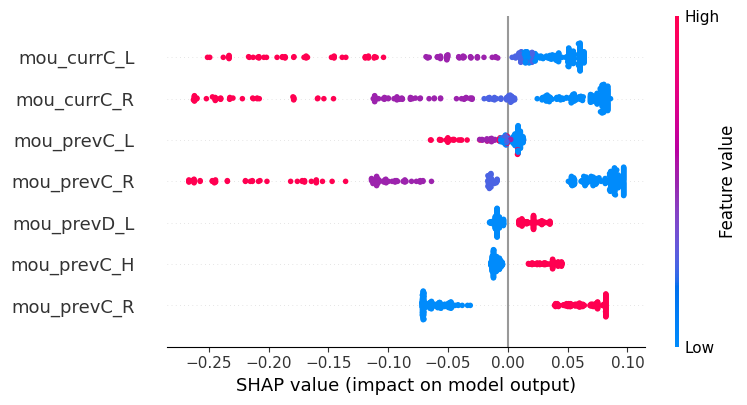

In [ ]:
shap.summary_plot(shap_values.values[:,:,0], X, sort=False,
                  feature_names=['mou_currC_L','mou_currC_R','mou_prevC_L','mou_prevC_R',
                                 'mou_prevD_L','mou_prevC_H','mou_prevC_R'])

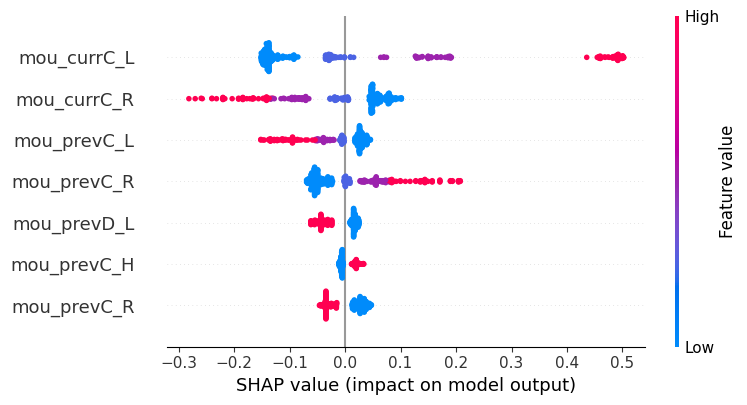

In [ ]:
shap.summary_plot(shap_values.values[:,:,1], X, sort=False,
                  feature_names=['mou_currC_L','mou_currC_R','mou_prevC_L','mou_prevC_R',
                                 'mou_prevD_L','mou_prevC_H','mou_prevC_R'])

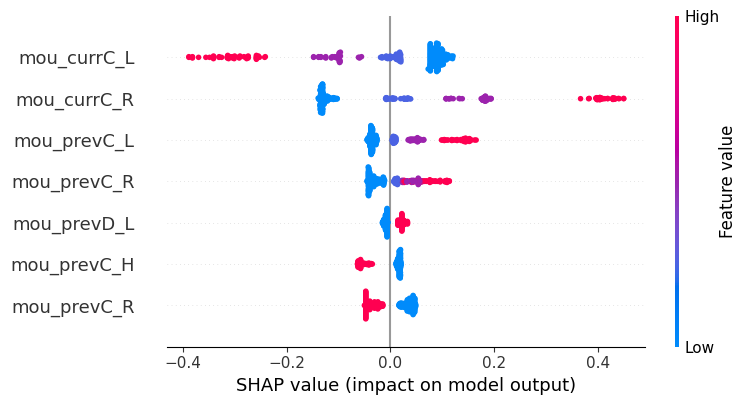

In [ ]:
shap.summary_plot(shap_values.values[:,:,2], X, sort=False,
                  feature_names=['mou_currC_L','mou_currC_R','mou_prevC_L','mou_prevC_R',
                                 'mou_prevD_L','mou_prevC_H','mou_prevC_R'])

In [ ]:
# just to hint adjustable parameters

summary_legacy(shap_values, features=None, feature_names=None, max_display=None, 
               plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, 
               show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, 
               class_names=None, class_inds=None, color_bar_label='Feature value', 
               cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x00000153979A5C90>, 
               show_values_in_legend=False, auto_size_plot=None, use_log_scale=False)


In [ ]:
# just to present the function details

from IPython.display import display, HTML  
import inspect  
  
def display_source(func):  
    source = inspect.getsource(func)  
    display(HTML(f"<pre>{source}</pre>"))  
  
display_source(shap.summary_plot)

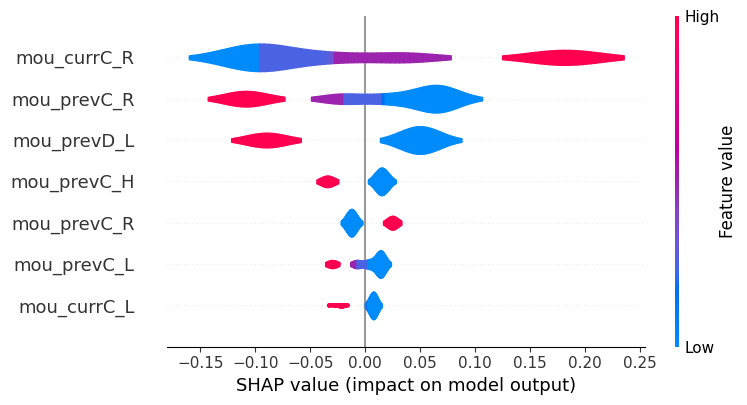

In [ ]:
shap.summary_plot(shap_values.values[:,:,2],X,plot_type='violin',
                  feature_names=['mou_currC_L','mou_currC_R','mou_prevC_L','mou_prevC_R',
                                 'mou_prevD_L','mou_prevC_H','mou_prevC_R'])

In [ ]:
shap_values.values

array([[[ 0.0606772 , -0.07128978,  0.01061257],
        [-0.02258693, -0.01560286,  0.03818978],
        [ 0.01162301,  0.02065082, -0.03227385],
        ...,
        [-0.04306863, -0.01029901,  0.05336764],
        [ 0.02723022,  0.00968447, -0.03691469],
        [ 0.0023495 ,  0.0110906 , -0.01344009]],

       [[-0.13049745,  0.15574739, -0.02524992],
        [-0.01705661, -0.02097885,  0.03803546],
        [-0.00319379, -0.01259836,  0.01579216],
        ...,
        [-0.03408332, -0.01721614,  0.05129947],
        [-0.00906446, -0.00667495,  0.01573941],
        [-0.00102144, -0.02734231,  0.02836376]],

       [[ 0.07340495, -0.08048352,  0.00707857],
        [ 0.05925109,  0.03492979, -0.09418088],
        [ 0.0079125 ,  0.0189334 , -0.02684588],
        ...,
        [-0.03970295, -0.00323383,  0.0429368 ],
        [ 0.02552252,  0.00543535, -0.03095787],
        [ 0.00035322,  0.010908  , -0.01126122]],

       ...,

       [[ 0.00801642, -0.0176231 ,  0.00960668],
        [-0